# Pronóstico de la evolución de pacientes con diabetes

## Descripción del problema real

Los tratamientos médicos están basados en las expectativas de recuperación o el avance de una enfermedad para tomar decisiones. En este caso, un equipo médico desea contar con pronósticos de pacientes con diabetes para tomar decisiones sobre su tratamiento.

## Descripción del problema en términos de los datos

Se desea determinar el progreso de la diabeteis un año hacia adelante a partir de las variables medidas para 442 pacientes. La información está almacenada en el archivo `datos/diabetes.csv`. Las variables medidas son: edad, sexo, indice de masa corporal, presión sanguinea y seis medidas de serum en la sangre. Se desea pronósticar el progreso de la enfermedad a partir de las variables dadas.

## Aproximaciones posibles

En este caso, se desea comparar los resultados de un modelo de regresión lineal y un modelo de redes neuronales artificiales.

## Requerimientos

Usted debe:

* Determinar cuáles de las variables consideradas son relevantes para el problema.


* Determinar si hay alguna transformación de las variables de entrada o de salida que mejore el pronóstico del modelo.


* Construir un modelo de regresión lineal que sirva como base para construir un modelo de redes neuronales artificiales.



* Construir un modelo de redes neuronales artificiales. Asimismo, debe determinar el número de neuronas en la capa o capas ocultas.


* Utiizar una técnica como crossvalidation u otra similar para establecer la robustez del modelo.

In [34]:
import logging
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
import math
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)

## Se leen los datos

In [2]:
diabetes_df = pd.read_csv("datos/diabetes.csv")

In [3]:
print(diabetes_df)


          age       sex       bmi        bp        s1        s2        s3  \
0    0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1   -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2    0.085299  0.050680  0.044451 -0.005671 -0.045599 -0.034194 -0.032356   
3   -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4    0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   
5   -0.092695 -0.044642 -0.040696 -0.019442 -0.068991 -0.079288  0.041277   
6   -0.045472  0.050680 -0.047163 -0.015999 -0.040096 -0.024800  0.000779   
7    0.063504  0.050680 -0.001895  0.066630  0.090620  0.108914  0.022869   
8    0.041708  0.050680  0.061696 -0.040099 -0.013953  0.006202 -0.028674   
9   -0.070900 -0.044642  0.039062 -0.033214 -0.012577 -0.034508 -0.024993   
10  -0.096328 -0.044642 -0.083808  0.008101 -0.103389 -0.090561 -0.013948   
11   0.027178  0.050680  0.017506 -0.033214 -0.007073  0.045972 -0.065491   

## Relacion entre variables

Hay muchas formas de ver como las variables estan relacionadas unas a otra, en este caso usaremos el metodo .corr() el cual toma cada variable y la compara con las otras, de esta forma nos da un valor numerico entre -1 y 1, entre mas cercano a uno o a menos uno mas se relacionara una con la otra y si se obtiene un valor muy cercano a 0 es que las varibles no tienen relacion o es muy poca, de esta forma obtenemos la siguiente tabla

In [4]:
diabetes_df.corr()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Y
age,1.000000,0.173737,0.185085,0.335427,0.260061,0.219243,-0.075181,0.203841,0.270777,0.301731,0.187889
sex,0.173737,1.000000,0.088161,0.241013,0.035277,0.142637,-0.379090,0.332115,0.149918,0.208133,0.043062
bmi,0.185085,0.088161,1.000000,0.395415,0.249777,0.261170,-0.366811,0.413807,0.446159,0.388680,0.586450
bp,0.335427,0.241013,0.395415,1.000000,0.242470,0.185558,-0.178761,0.257653,0.393478,0.390429,0.441484
s1,0.260061,0.035277,0.249777,0.242470,1.000000,0.896663,0.051519,0.542207,0.515501,0.325717,0.212022
s2,0.219243,0.142637,0.261170,0.185558,0.896663,1.000000,-0.196455,0.659817,0.318353,0.290600,0.174054
s3,-0.075181,-0.379090,-0.366811,-0.178761,0.051519,-0.196455,1.000000,-0.738493,-0.398577,-0.273697,-0.394789
s4,0.203841,0.332115,0.413807,0.257653,0.542207,0.659817,-0.738493,1.000000,0.617857,0.417212,0.430453
s5,0.270777,0.149918,0.446159,0.393478,0.515501,0.318353,-0.398577,0.617857,1.000000,0.464670,0.565883
s6,0.301731,0.208133,0.388680,0.390429,0.325717,0.290600,-0.273697,0.417212,0.464670,1.000000,0.382483


Como se puede observar s1 y s2 tienen la mas alta relacion entre ellas de todas las variables del modelo ya que se ve un valor de: 0.896663. Por este motivo borraremos s2

Adicionalmente s4 y s3 tambien tienen una alta relacion, sin embargo esta es una relacion positiva como en el anterior caso si no que es negativa con un valor de: -0.738493. Por este motivo borraremos s4

El resto de variables parecen tener una importancia para el modelo por lo que solo eliminaremos esas 2

In [5]:
diabetes_df = diabetes_df.drop(['s2', 's4'], axis=1)
print(diabetes_df)

          age       sex       bmi        bp        s1        s3        s5  \
0    0.038076  0.050680  0.061696  0.021872 -0.044223 -0.043401  0.019908   
1   -0.001882 -0.044642 -0.051474 -0.026328 -0.008449  0.074412 -0.068330   
2    0.085299  0.050680  0.044451 -0.005671 -0.045599 -0.032356  0.002864   
3   -0.089063 -0.044642 -0.011595 -0.036656  0.012191 -0.036038  0.022692   
4    0.005383 -0.044642 -0.036385  0.021872  0.003935  0.008142 -0.031991   
5   -0.092695 -0.044642 -0.040696 -0.019442 -0.068991  0.041277 -0.041180   
6   -0.045472  0.050680 -0.047163 -0.015999 -0.040096  0.000779 -0.062913   
7    0.063504  0.050680 -0.001895  0.066630  0.090620  0.022869 -0.035817   
8    0.041708  0.050680  0.061696 -0.040099 -0.013953 -0.028674 -0.014956   
9   -0.070900 -0.044642  0.039062 -0.033214 -0.012577 -0.024993  0.067736   
10  -0.096328 -0.044642 -0.083808  0.008101 -0.103389 -0.013948 -0.062913   
11   0.027178  0.050680  0.017506 -0.033214 -0.007073 -0.065491 -0.096433   

# Comparacion entre transformaciones

Para esto aplicaremos diferentes transformaciones a los datos para poder visualizar si alguna de ellas nos mejora el error que se obtiene de forma inicial (transformacion identidad), no usaremos ln ni raiz ya que en los datos hay numeros negativos por lo que no es una transformacion recomendable

In [61]:
transformations = [("Funcion Cuadratica", lambda x: x**2),
                   ("Funcion Exponencial", lambda x: np.exp(x)),
                   ("Funcion Identidad", lambda x: x)]

for name, transformation in transformations:
    df = diabetes_df.apply(transformation)
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['Y'], axis=1), 
                                                        df['Y'], test_size=0.30)
    
    lm = LinearRegression()
    lm.fit(X_train,y_train)
    predictions = lm.predict(X_test)
    print( name )
    print('MAE:', metrics.mean_absolute_error(y_test, predictions))
    print('MSE:', metrics.mean_squared_error(y_test, predictions))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
    print(" \n")
    
    

Funcion Cuadratica
MAE: 20220.85865378829
MSE: 611888987.7859542
RMSE: 24736.389950555724
 

Funcion Exponencial
MAE: 1.9800893942119126e+148
MSE: 6.5176845077311026e+296
RMSE: 2.5529756183189653e+148
 

Funcion Identidad
MAE: 45.698230046662076
MSE: 3304.2330813834183
RMSE: 57.482458901680765
 



El error mas pequeño se obtiene con la identidad, es decir sin hacer transformacion a los datos, es por este motivo que lo mejor es trabajar con los datos en su forma original y de esta forma minimizar el error

# Modelo

In [7]:
x=diabetes_df.drop(['Y'],axis=1)
y=diabetes_df[['Y']]
y=np.reshape(y, (-1,1))
scaler = MinMaxScaler()
print(scaler.fit(x))
print(scaler.fit(y))
xscale=scaler.transform(x)
yscale=scaler.transform(y)
X_train, X_test, y_train, y_test = train_test_split(xscale, yscale, test_size=0.30)

MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))


In [8]:
def print_history(history, units):    
    print(history.history.keys())
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Perdida del modelo con ' + str(units) + " unidades")
    plt.ylabel('Perdida')
    plt.xlabel('Periodo')
    plt.legend(['Entrenamiento', 'validacion'], loc='upper left')
    plt.show()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3)                 27        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4         
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])


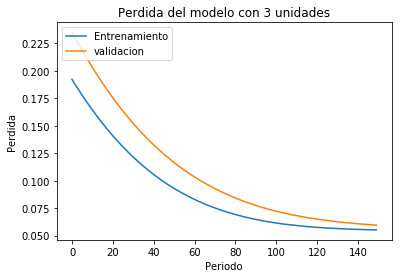

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12)                108       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 13        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])


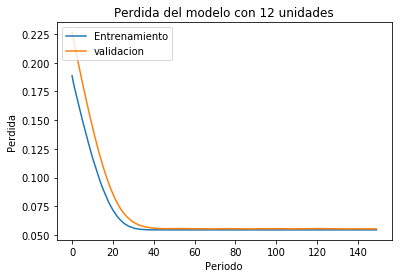

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 243)               2187      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 244       
Total params: 2,431
Trainable params: 2,431
Non-trainable params: 0
_________________________________________________________________
dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])


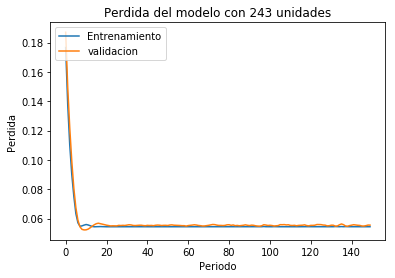

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 2187)              19683     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 2188      
Total params: 21,871
Trainable params: 21,871
Non-trainable params: 0
_________________________________________________________________
dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])


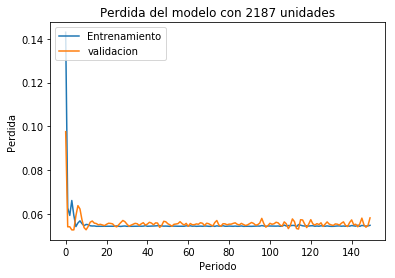

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 6561)              59049     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 6562      
Total params: 65,611
Trainable params: 65,611
Non-trainable params: 0
_________________________________________________________________
dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])


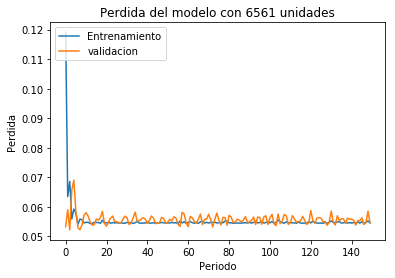

In [9]:
quantity_of_neurons = [3, 12, 243, 2187, 6561]
for units in quantity_of_neurons:
    model = Sequential()
    model.add(Dense(units, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.summary()
    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
    history = model.fit(X_train, y_train, epochs=150, batch_size=70, verbose=0, validation_split=0.15)
    print_history(history, units)

En este caso se tomo una cantidad de neuronas aleatorias en multiplos de 3, se puede ver que a partir de 12 se vuelven muy parecidos los modelos y cuando las neuronas son muchas empieza a haber mas fluctiacion en las perdidas, 3 al parecer son muy pocas pero en un numero cercano a 12 parece estar el equilibrio ya que se vuelve practicamente constante las perdidas y no fluctua mucho

# Comparacion de resultados

In [65]:
X = diabetes_df.drop(["Y"],axis = 1).values
y = diabetes_df["Y"].values

def cross_validation(train_index, test_index,X,y):    
    
    X_train, X_test = pd.DataFrame(X[train_index]), pd.DataFrame(X[test_index])
    y_train, y_test = pd.DataFrame(y[train_index]), pd.DataFrame(y[test_index])
    
    X_train.columns = ['age', 'sex', 'bmi', 'bp', 's1', 's3', 's5', 's6']
    X_test.columns = X_train.columns = ['age', 'sex', 'bmi', 'bp', 's1', 's3', 's5', 's6']

    sex = tf.feature_column.numeric_column('sex')
    bmi = tf.feature_column.numeric_column('bmi')
    bp = tf.feature_column.numeric_column('bp')
    s1 = tf.feature_column.numeric_column('s1')
    s5 = tf.feature_column.numeric_column('s5')
    s6 = tf.feature_column.numeric_column('s6')

    feat_cols = [sex, bmi, bp, s1, s5, s6]
    input_func = tf.estimator.inputs.pandas_input_fn(x=X_train,
                                                     y= y_train[0],
                                                     batch_size=10,
                                                     num_epochs=3000,
                                                     shuffle=False)
    
    model = tf.estimator.DNNRegressor(hidden_units=[4,4,4],feature_columns=feat_cols)

    model.train(input_fn=input_func,steps=5000)

    predict_input_func = tf.estimator.inputs.pandas_input_fn(
        x=X_test,
        batch_size=10,
        num_epochs=1,
        shuffle=False)

    pred_gen = model.predict(predict_input_func)

    predictions = list(pred_gen)

    final_preds = []

    for pred in predictions:
        final_preds.append(pred['predictions'])   

    return metrics.mean_squared_error(y_test, final_preds)

from sklearn.model_selection import KFold
kf = KFold(n_splits=4)

resultado_cross = []

for train_index, test_index in kf.split(X):    
    resultado_cross.append(cross_validation(train_index,test_index,X,y))
    
print("MSE del Cross validation: ", np.array(resultado_cross).sum()/len(resultado_cross))

MSE del Cross validation:  3146.745995859651


Como se puede observar el MSE dio menor al que se habia producido anteriormente por lo que la red neuronal es efectiva aunque no haya mucha diferencia